# Distributed Machine Learning with Dask

## Reference

**Data Science with Python and Dask**  ([online access via SNU library](https://learning.oreilly.com/library/view/data-science-with/9781617295607/))

[![asdf](https://learning.oreilly.com/covers/urn:orm:book:9781617295607/400w/)](https://learning.oreilly.com/library/view/data-science-with/9781617295607/)


## Reading HDF5 Data File

In [1]:
%matplotlib inline

import wget
import h5py

# fname = wget.download('https://sandbox.zenodo.org/record/1027635/files/mnist.hdf5?download=1')
fname = 'mnist.hdf5'
f = h5py.File(fname)

## Introducing Dask

https://learning.oreilly.com/library/view/data-science-with/9781617295607/c02.xhtml#h2-295607c02-0003

In [32]:
import numpy as np
import pandas as pd

import dask.array as da
from dask_ml.model_selection import train_test_split

X = da.from_array(f['training-images'][0:10000], chunks=1000)
y = da.from_array(f['training-labels'][0:10000], chunks=1000)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=0)

In [3]:
X_train

dask.array<concatenate, shape=(5000, 784), dtype=uint8, chunksize=(500, 784), chunktype=numpy.ndarray>

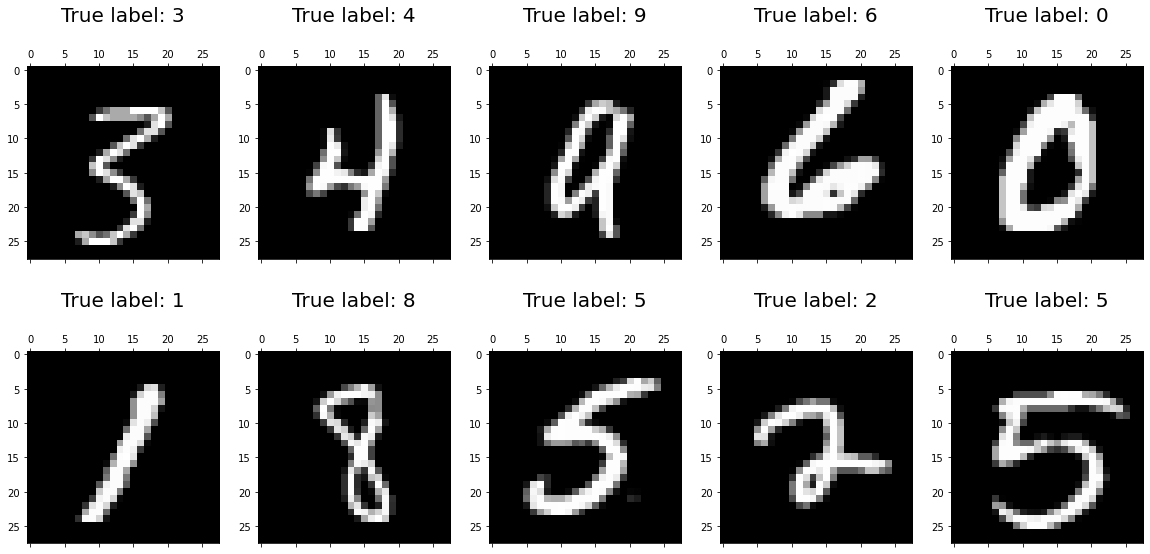

In [40]:
def plot_digits(X_, y_, num_figs, y_caption='True label'):

    from matplotlib.pyplot import figure
    from numpy import ceil

    num_rows = ceil(num_figs/5).astype(int)

    fig = figure(figsize=(20, 4.8*num_rows))

    # for j, ((i, img), (i, lab)) in enumerate(zip(X_, y_)):
    for j, (img, lab) in enumerate(zip(X_, y_)):

        tf = fig.add_subplot(num_rows, 5, j+1)
        tf.matshow(img.reshape((28, -1)), cmap='gray')
        tf.set_title('%s: %s\n' % (y_caption, lab.compute()), fontsize = 20)

        if j+1 == num_figs: break

plot_digits(X_train, y_train, 10)

In [4]:
from dask.distributed import Client, progress
from joblib import parallel_backend

client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.0.149.93:8787/status,
Dashboard: http://10.0.149.93:8787/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://10.0.149.93/121/1,Workers: 1
Dashboard: http://10.0.149.93:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://10.0.149.93/121/4,Total threads: 4
Dashboard: http://10.0.149.93:44705/status,Memory: 1.86 GiB
Nanny: None,


## Classification with Random Forest - Dask Backend

In [43]:
from sklearn.ensemble import RandomForestClassifier

yhat_test = dict()

with parallel_backend('dask'):

    clf = RandomForestClassifier()

    %time clf.fit(X_train, y_train)

    yhat_test['RandomForestDask'] = clf.predict(X_test)

print((yhat_test['RandomForestDask'] == y_test).mean().compute())

# grp_test = pd.Series(yhat_test['RandomForest'].astype('str'), dtype='category')

CPU times: user 4.04 s, sys: 170 ms, total: 4.21 s
Wall time: 4.22 s
0.937


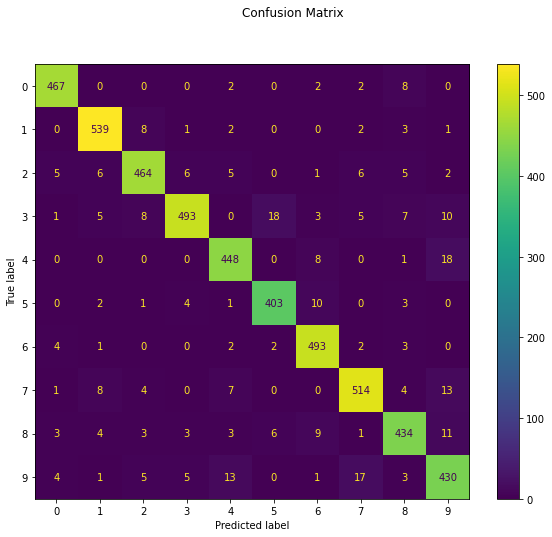

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, yhat_test['RandomForestDask'])
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8))

## Classification with Random Forest + Hyperparameter optimization - Dask Backend

In [36]:
from dask_ml.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()
param_grid = {
    'weights': ['uniform', 'distance'],
}
# param_grid = {}

grid_search = GridSearchCV(estimator,
                param_grid=param_grid,
                return_train_score=False,
                cv=3)

with parallel_backend('dask'):
# with parallel_backend('dask', scatter=[X_train, y_train]):

    grid_search.fit(X_train, y_train)

    print(grid_search.best_estimator_.get_params())

    yhat_test['RandomForestGridSearch'] = grid_search.best_estimator_.predict(X_test)

print((yhat_test['RandomForestGridSearch'] == y_test).mean().compute())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.9408


In [38]:
grid_search.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

## Clustering with distributed KMeans

In [39]:
from dask_ml.cluster import KMeans
clf = KMeans(init='k-means++', n_clusters=10, init_max_iter=4, random_state=0)
%time clf.fit(X_train)
clf.labels_
clf.labels_[:10].compute()

CPU times: user 40.1 s, sys: 37.9 s, total: 1min 18s
Wall time: 1min 19s


array([3, 0, 2, 2, 9, 4, 3, 6, 3, 5], dtype=int32)

In [46]:
clf.labels_

AttributeError: 'RandomForestClassifier' object has no attribute 'labels_'

In [41]:
from sklearn.ensemble import RandomForestClassifier

yhat_test = dict()

# module loading
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

yhat_test['RandomForest'] = clf.predict(X_test)

print((yhat_test['RandomForest'] == y_test).mean().compute())

0.9366


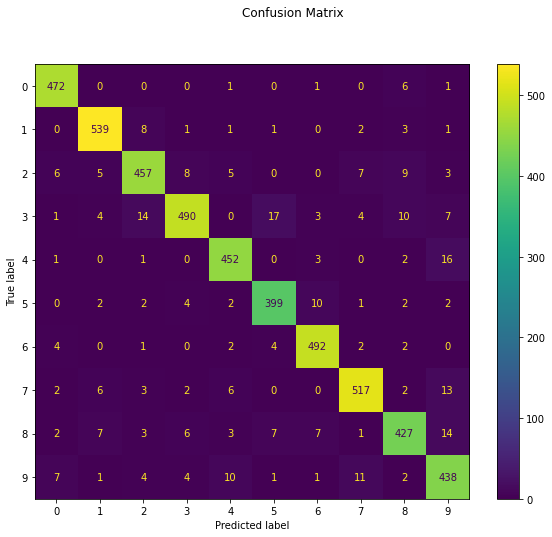

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, yhat_test['RandomForest'])
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.set_size_inches((10, 8));

In [14]:
import numpy as np

cluster_label = dict()
for one in np.unique(grp_test):
    majority = y_test[(grp_test==one).values].value_counts()
    print('Majority of points in cluster', one, 'have label', majority.idxmax())
    cluster_label[str(one)] = majority.idxmax()

AttributeError: 'Array' object has no attribute 'value_counts'

In [24]:
def subset_images(X_, y_, cluster_, digit, cl):

    cond = (cluster_ == cl) & (y_ == digit)

    return X_[cond], y_[cond], cluster_[cond]

0

In [25]:
# upright
d, l, c = subset_images(X_test, y_test, grp_test, 1, 0)
plot_digits(d, c, 5, 'cluster')

<Figure size 1440x345.6 with 0 Axes>

dask.array<concatenate, shape=(5000, 784), dtype=uint8, chunksize=(500, 784), chunktype=numpy.ndarray>

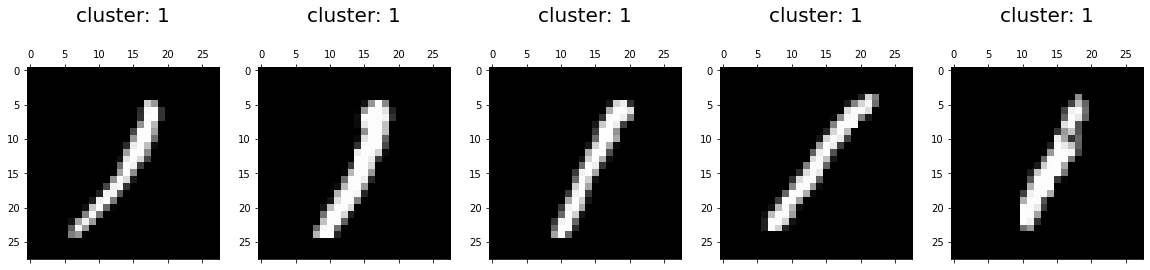

In [ ]:
# slanted
d, l, c = subset_images(X_test, y_test, grp_test, '1', '1')
plot_digits(d, c, 5, 'cluster')

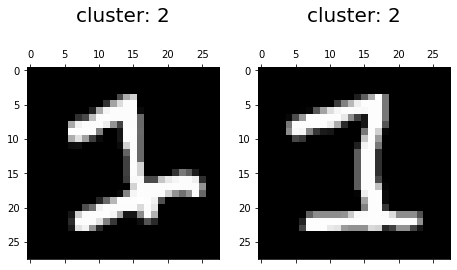

In [ ]:
# fancy
d, l, c = subset_images(X_test, y_test, grp_test, '1', '2')
plot_digits(d, c, 5, 'cluster')

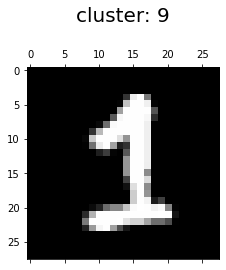

In [ ]:
# fancy upright
d, l, c = subset_images(X_test, y_test, grp_test, '1', '9')
plot_digits(d, c, 5, 'cluster')